# Import Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Download Data Set

In [2]:
import pathlib

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos.tar', origin=dataset_url, extract=True)
data_dir = pathlib.Path(data_dir).with_suffix('')

**Verify by Counting Images in Set, 3670 total images provided to us**

In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


**5 Sub-sets**


*   Daisy
*   Dandelion
*   Roses
*   Sunflowers
*   Tulips



In [ ]:
daisy = list(data_dir.glob('sunflowers/*'))
PIL.Image.open(str(daisy[0]))

# Create training & validation data sets

In [4]:
batch_size = 16
img_height = 180
img_width = 180

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [7]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


Below we preview the first 9 images of the dataset with labels. You can see the bottom right image looks problematic.

(16, 180, 180, 3)
(16,)


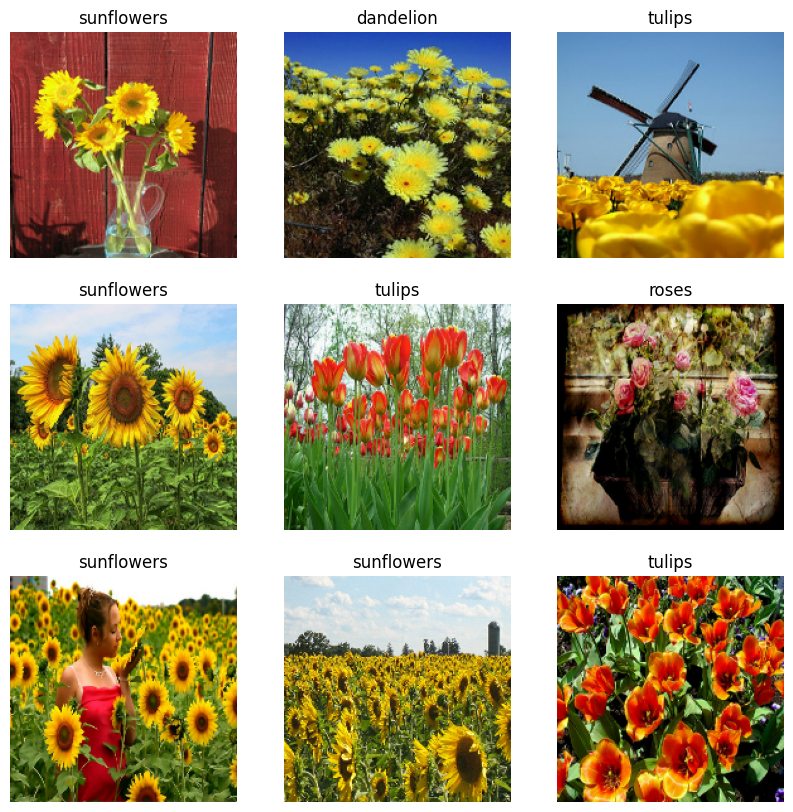

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

The (32, 180, 180, 3) shows 32 images of 180 x 180 x 3 (3 is for color channels RGB) This is just the shape of our Tensor

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

# Data Pre-processing

Running tf.data.AUTOTUNE will optimize our prefetching by preventing I/O from becoming blocking when we get data from the disk.

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Because RGB is a 0:255 array, we want to normalize it to 0:1 using tf.keras.Rescaling

In [10]:
normalization_layer = layers.Rescaling(1./255)

Using Dataset.map to standardize the RGB values by applying the above normalization_layer. You can see final output is in range 0:1

In [11]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0011438258 0.9905011


# Training the Model

Using the Sequential model consisting of 3 convolution blocks with a Max Pooling layer in each of them. 128 node layer activated by ReLU function.

In [12]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

Choosing an optimizer and loss function, passing Metrics argument into model.compile to view training and validation accuracy

In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

In [14]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
184/184 [==============================] - 10s 23ms/step - loss: 1.2252 - accuracy: 0.4922 - val_loss: 1.0429 - val_accuracy: 0.5736
Epoch 2/10
184/184 [==============================] - 2s 12ms/step - loss: 0.9150 - accuracy: 0.6536 - val_loss: 0.9110 - val_accuracy: 0.6335
Epoch 3/10
184/184 [==============================] - 2s 12ms/step - loss: 0.6948 - accuracy: 0.7347 - val_loss: 0.8682 - val_accuracy: 0.6608
Epoch 4/10
184/184 [==============================] - 2s 13ms/step - loss: 0.4349 - accuracy: 0.8382 - val_loss: 0.9300 - val_accuracy: 0.6703
Epoch 5/10
184/184 [==============================] - 2s 12ms/step - loss: 0.2162 - accuracy: 0.9257 - val_loss: 1.1756 - val_accuracy: 0.6403
Epoch 6/10
184/184 [==============================] - 2s 12ms/step - loss: 0.1224 - accuracy: 0.9653 - val_loss: 1.2814 - val_accuracy: 0.6839
Epoch 7/10
184/184 [==============================] - 2s 12ms/step - loss: 0.0827 - accuracy: 0.9728 - val_loss: 1.4051 - val_accuracy: 0.673

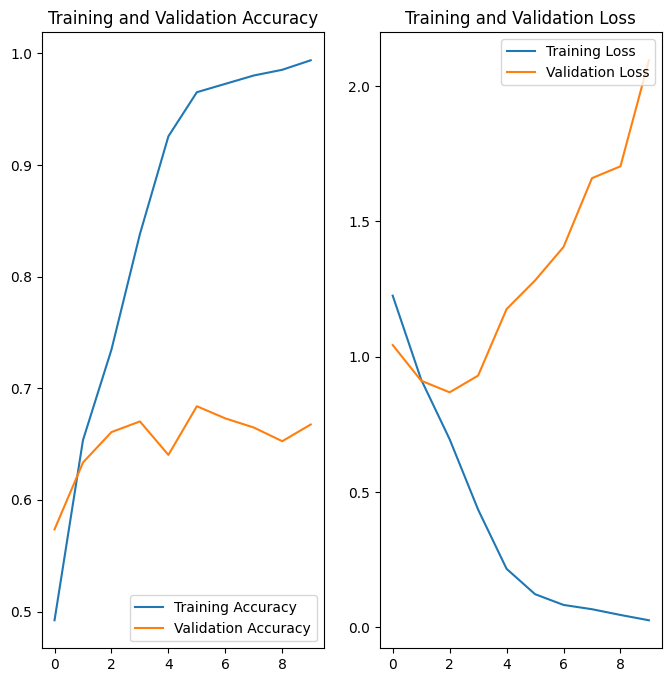

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
print(acc[9])

In [ ]:
def random_invert_img(x, p=0.5):
  if  tf.random.uniform([]) < p:
    x = (255-x)
  else:
    x
  return x

Initial Training accuracy 98.6% but validation accuracy ~65%

In [16]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                    input_shape=(img_height,
                                img_width,
                                3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomBrightness(0.2),
    layers.RandomTranslation(0.1,0.1),
  ]
)

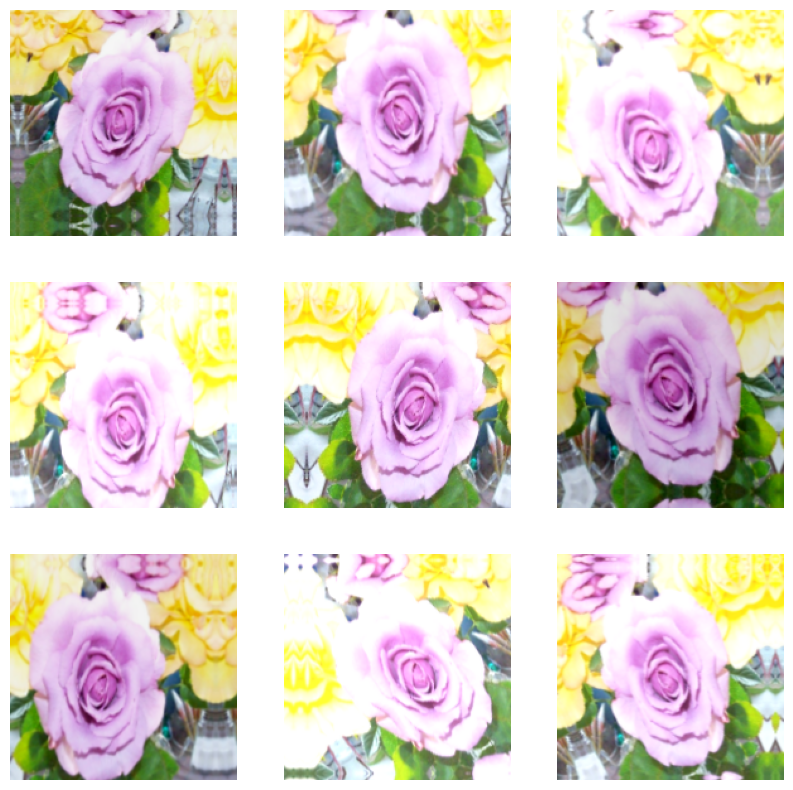

In [17]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [18]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(96, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(96, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

In [20]:
epochs = 25
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/25
184/184 [==============================] - 12s 39ms/step - loss: 1.3216 - accuracy: 0.4125 - val_loss: 1.2785 - val_accuracy: 0.4823
Epoch 2/25
184/184 [==============================] - 6s 31ms/step - loss: 1.1029 - accuracy: 0.5688 - val_loss: 1.0336 - val_accuracy: 0.6076
Epoch 3/25
184/184 [==============================] - 6s 32ms/step - loss: 0.9910 - accuracy: 0.6056 - val_loss: 0.8965 - val_accuracy: 0.6540
Epoch 4/25
184/184 [==============================] - 6s 31ms/step - loss: 0.9176 - accuracy: 0.6495 - val_loss: 0.8506 - val_accuracy: 0.6826
Epoch 5/25
184/184 [==============================] - 6s 31ms/step - loss: 0.8988 - accuracy: 0.6526 - val_loss: 0.8531 - val_accuracy: 0.6703
Epoch 6/25
184/184 [==============================] - 6s 32ms/step - loss: 0.8318 - accuracy: 0.6788 - val_loss: 0.9618 - val_accuracy: 0.6526
Epoch 7/25
184/184 [==============================] - 6s 31ms/step - loss: 0.8023 - accuracy: 0.6860 - val_loss: 0.8232 - val_accuracy: 0.682

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
print(acc[9])

In [ ]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

In [ ]:
flower_url = "https://media.istockphoto.com/id/1393708668/photo/tulips.jpg?s=1024x1024&w=is&k=20&c=V17eN2Xrwy47I6BgPMfpMSRcgXfFZKcVc8QYHTdHWSY="
flower_path = tf.keras.utils.get_file(origin=flower_url)

img = tf.keras.utils.load_img(
    flower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)